## Introduction

This notebook explores data from the Seattle dataset from Airbnb, retrieved from: https://www.kaggle.com/airbnb/seattle/data

The following Airbnb activity is included in this Seattle dataset:

* Listings, including full descriptions and average review score
* Reviews, including unique id for each reviewer and detailed comments
* Calendar, including listing id and the price and availability for that day

The goal is to highlight and answer three relevant questions that might be relevant for business purposes.

## 0) Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## 1) Trend of Airbnb listings and visitors

To see how the Airbnb market in Seattle grew over time, we can count the number of new listings per month. In addition, we can approximated the number of visitors per month and its trend by using the number of reviews of guests.

In [2]:
#Import datasets
listings=pd.read_csv('data\\listings.csv')
reviews=pd.read_csv('data\\reviews.csv')

In [3]:
#Convert review date to datetime and extract month/month-year
reviews['date']=pd.to_datetime(reviews['date'])
reviews['month']=reviews['date'].dt.month
reviews['month-year']=reviews['date'].dt.strftime('%Y-%m')

In [4]:
#Convert first review date of lisiting to datetime and extract month/month-year
listings['first_review']=pd.to_datetime(listings['first_review'])
listings_clean=listings.dropna(subset=['first_review']).copy()
listings_clean['month_first_review']=listings_clean['first_review'].dt.strftime('%Y-%m')

In [5]:
#Group number of new listings and reviews by month and store as timeseries
data1=listings_clean[listings_clean['first_review']<'2016'].groupby('month_first_review').agg('count')
data2=reviews[reviews['date']<'2016'].groupby('month-year').agg('count')

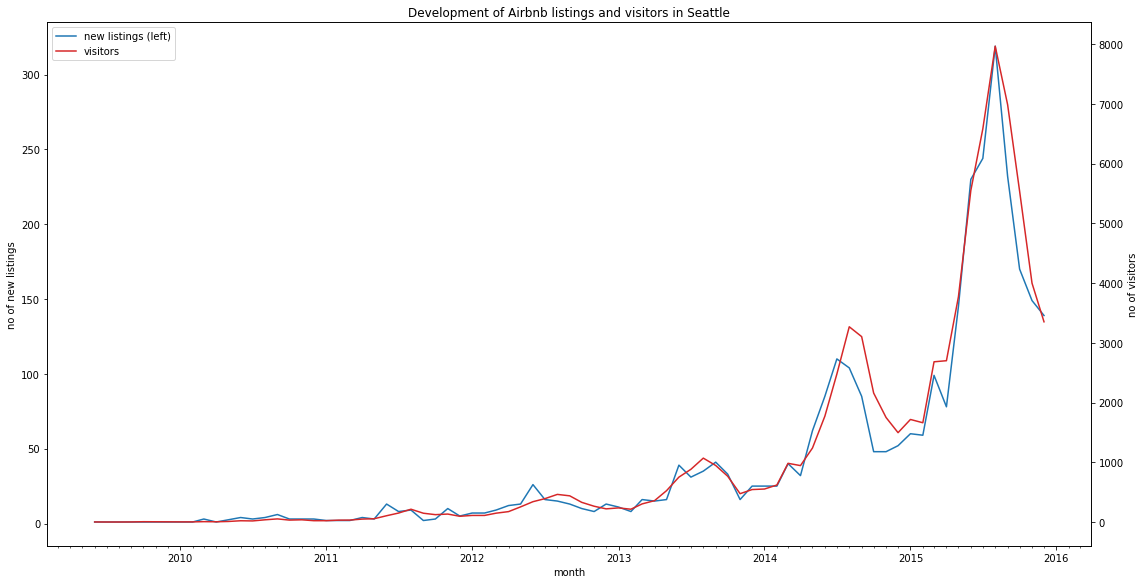

In [7]:
#Plot timeseries
fig, ax1 = plt.subplots(figsize=(16,8))

years = mdates.YearLocator()   #every year
months = mdates.MonthLocator()  #every month
years_fmt = mdates.DateFormatter('%Y')

#plot new listings ts
color = 'tab:blue'
line1=ax1.plot(pd.to_datetime(data1.index), data1['id'], color=color, label='new listings (left)')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#plot new reviews/visitors ts
color = 'tab:red'
line2=ax2.plot(pd.to_datetime(data2.index), data2['reviewer_id'], color=color, label='visitors')

# format the ticks
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)

# format the coords message box
ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')

#format axis
ax1.set_xlabel('month')
ax1.set_ylabel('no of new listings')
ax2.set_ylabel('no of visitors')

#format legend
lns = line1+line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()
plt.title('Development of Airbnb listings and visitors in Seattle')
plt.savefig('img\\01_listings_visitors_trend.jpg',dpi=100)
plt.show()

## 2) Seasonality of price and availability

We want to see if the price and availability of a listing varies with the calendar month. We can look at average prices and availability of listings by month using the calendar dataset.

In [ ]:
#Import dataset
calendar=pd.read_csv('calendar.csv')

In [ ]:
#Convert review date to datetime and extract month
calendar['date']=pd.to_datetime(calendar['date'])
calendar['month']=calendar['date'].dt.month

In [ ]:
#Convert availability and price to numeric
calendar['available'].replace(['t','f'],[1,0],inplace=True)
calendar['price']=pd.to_numeric(calendar['price'].str[1:-3].str.replace(',',''))

In [ ]:
#Calculate average price and availability by month
data=calendar.groupby('month').agg('mean')[['available','price']]

In [ ]:
#Plot timeseries
fig, ax1 = plt.subplots(figsize=(16,8))

color = 'tab:blue'
line1=ax1.plot(data['available'], color=color, label='available (left)')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
line2=ax2.plot(data['price'], color=color, label='price')

#format axis
ax1.set_xlabel('month')
ax1.set_ylabel('Average availability')
ax2.set_ylabel('Average price per night')
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xticks(range(1,13),['January', 'February', 'March', 'April', 'May', 'June',
                     'July', 'August', 'September', 'October', 'November', 'December'])

#format legend
lns = line1+line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()
plt.title('Seasonality of price and availability of Airbnb 2016 listings in Seattle')
plt.savefig('img\02_price_seasonality.jpg',dpi=100)
plt.show()

## 3) Build a forecast model to predict listing price per night

What if you wanted to offer your own Seattle appartment at Airbnb? How much would you be able to earn per night?
We build a OLS model to see what drives listing prices and to predict what we can hope to earn. 

In [ ]:
#Import dataset
df=pd.read_csv('data\\listings.csv')

In [ ]:
#Drop all features with more than 75% missing
df=df[df.columns[~(df.isnull().sum()/df.shape[0]>.75)]]

In [ ]:
#Drop missing prices and convert to numeric
df['price']=pd.to_numeric(df['price'].str[1:-3].str.replace(',',''))
df = df.dropna(subset=['price'], axis=0)

In [ ]:
#Create dependent variable
y = df['price']

In [ ]:
#Drop all categorical vars with more than 20 unique values or less than 2. 
#This way we get rid of 'non-sensical' columns, like listing_url, that likely will not explain price.

all_cat_cols=df.select_dtypes(include=['object']).columns
drop_cat_cols=all_cat_cols[(df[all_cat_cols].nunique()<=1)|(df[all_cat_cols].nunique()>20)].values
df=df.drop(drop_cat_cols,axis=1)

In [ ]:
#Drop additional column with limited information value (ids), no variability (city, state = Seattle, WA),
#or columns that are perfectly correlated with other explanatory features ('host_total_listings_count').

drop_other_cols=['price','id', 'scrape_id', 'host_id', 'host_total_listings_count',
                 'calculated_host_listings_count','state','city','smart_location']
df=df.drop(drop_other_cols,axis=1)

In [ ]:
#Convert to categorical columns to dummies and drop
cat_cols=df.select_dtypes(include=['object']).columns
for var in cat_cols:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [ ]:
#Fill missing numeric values with the mean
num_vars = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_vars:
    df[col].fillna((df[col].mean()), inplace=True)

Now that we have prepared the data, we can train our model.

In [ ]:
#Create explanatory variables
X=df

#Split dataset in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

#Instatiate and train model
lm_model = OLS(y_train,X_train).fit()

#Print model results
lm_model.summary()

The model yields a relatively high adjusted R-squared of 87%. We find a lot features that have a materially siginficant impact on the listing price. However, not all of them are statistically significant. We only want to see features where we can be very certain that the coefficient is not a random result but actually robust and reliable. To do that, we filter out only coefficients of feautres with p-value < 1%. 

In [ ]:
#Store model results in dataframe
results=pd.DataFrame()
results['coefficient']=lm_model.params
results['abs_coefficient']=np.abs(lm_model.params)
results['p_value']=lm_model.pvalues

In [ ]:
#Filter for features wit p<1% and print sorted list
sig_vars=results[results['p_value']<.01].sort_values('abs_coefficient',ascending=False).index
results[results['p_value']<.01].sort_values('abs_coefficient',ascending=False)

We will retrain the model with only statistically significant features.

In [ ]:
#Create explanatory variables (only stat. signifcant)
X=df[sig_vars]

#Split dataset in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

#Instatiate and train model
lm_model = OLS(y_train,X_train).fit()

#Evaluate model fit on test set
y_hat=lm_model.predict(X_test)
r2=r2_score(y_test,y_hat)

print("The R-squared of the model prediction on the test set is: {:.1%}".format(r2))